In [1]:
%matplotlib inline

%reload_ext autoreload
%autoreload 2

import keras

#from keras_retinanet.models import retinanet
#from keras_retinanet import models
#from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
#from keras_retinanet.utils.visualization import draw_box, draw_caption
#from keras_retinanet.utils.colors import label_color

from PIL import Image

import matplotlib.pyplot as plt
import cv2
import numpy as np
import time
import json
import os
import warnings

In [23]:
#model_path = '../../Data/harbor-seals/models/harbor_seal_model_no_other.h5'
#model = models.load_model(model_path, backbone_name='resnet50')

labels_to_names = {0: 'bull', 1: 'cow', 2: 'pup', 3: 'other', 
                   4: 'bull wrong', 5: 'cow wrong', 6: 'pup wrong', 7: 'other wrong'}


In [20]:
image_prefix = '../../Data/elephant-seals/test/'
image_list_full = [
    '5MSL3749-174_png.rf.1ade9f0908936fd853dc2ae9a0f00233.jpg',
     '5MSL3764-21_png.rf.d67ea7373c5b15df832b5e11d4d59192.jpg',
     '5MSL3819-65_png.rf.7cf3c5254e14e6b5cf5905c04ef3f848.jpg',
     '5MSL0109-125_png.rf.0999b3e2f7414ce671eb6ece5f074af1.jpg',
     '5MSL0109-4_png.rf.4c177bee4ff3cdfb044448de4af8f62c.jpg',
     '5MSL0087-138_png.rf.6843d941557d06ab666d79fe30071175.jpg',
     '5MSL4416-99_png.rf.1e915260973f7fd233ef130506a02836.jpg',
     '4MSL0120-163_png.rf.fec5aded76dfdbf287db0a33cffecb65.jpg',
     '5MSL3749-24_png.rf.c0d599cb5e1a10d9bb787cbdbef5e201.jpg',
     '5MSL1479-6_png.rf.c9a1b45ca0cc3abd059facca39256aff.jpg',
     '5MSL3749-146_png.rf.adb2315a6cc0e239980419d05ae2fcab.jpg',
     '4MSL0119-104_png.rf.0f73c19f543a90b15c12dc72bf972446.jpg',
     '5MSL0087-120_png.rf.ea046df0b3121de73453abcfc2f6fcb6.jpg',
     '5MSL0109-84_png.rf.e1d78f59110465473cd83883edd58ab0.jpg',
     '5MSL3436-6_png.rf.4ea434812bb5b4e80c37b85c5103168d.jpg',
     '5MSL0095-98_png.rf.d0a2d706df7b447719994fd7de1f7d36.jpg',
     '5MSL0087-22_png.rf.b500d2b83eb6a2b9d76fcd6cbe9c55af.jpg',
     '5MSL0109-95_png.rf.73ae554e192ba0a1cb271ec123f8330f.jpg',
     '5MSL3436-15_png.rf.10de22d575068c5c4d52c255e5c56cfa.jpg',
     '4MSL0120-169_png.rf.374080801c483f31562d9e265eb66652.jpg',
     'MA263076-124_png.rf.42e9d6beed2e154f9051414a40aae592.jpg',
     '5MSL0089-142_png.rf.00c837be2517e38115a9bcd28e1acb21.jpg',
     '5MSL3764-132_png.rf.eaaa0fa497455e8c42fb6698f4f1f125.jpg',
     '5MSL3436-115_png.rf.d2ebe4ef97473624b43c17e3373c338d.jpg',
     '5MSL3764-18_png.rf.7dd55fc701e3f0ec09ef893668bbb45d.jpg',
     '5MSL3764-134_png.rf.294fa1f2ec3227e20995494de77ac3f4.jpg',
     '5MSL3764-76_png.rf.2bfc3f67fdfefc7715222d7aad08ae9c.jpg',
     '4MSL0120-140_png.rf.03e7f0b7cf647b4b8793a1fbaa15844e.jpg',
     '5MSL3819-55_png.rf.a7ec0f8019e2d7ee1d781867ea416e53.jpg',
     '5MSL0087-112_png.rf.d74dfca1a15442986c922680263769f5.jpg',
     '5MSL0019-47_png.rf.abd556ad1262d88c05f035864ab95be2.jpg',
     'MA262988-171_png.rf.6d746f67067125adb31283c14052f12c.jpg',
     '4MSL0120-175_png.rf.93c8f9d5153f911143651f418f06eacb.jpg',
     '4MSL0119-148_png.rf.e00ecbfdbf3158afb96f78f40ceecfcd.jpg',
     '4MSL0119-113_png.rf.0c51d0505db734bdeae1913e43760ebf.jpg',
     '4MSL0119-67_png.rf.758a0d45240eaa61ad24cf86298f3332.jpg',
     '5MSL3819-48_png.rf.b37d718edf1faf1f279c760d23685211.jpg',
     '5MSL3819-168_png.rf.c791f19bc213d15a6cb4a1c8839261c0.jpg',
     '5MSL0049-23_png.rf.aa4142b069ab92c6eafd7f01633095d5.jpg',
     '5MSL4383-68_png.rf.5360242ffe1ca1a0da6d0062d96169b0.jpg']

In [21]:
image_list = ['4MSL0119-104_png.rf.0f73c19f543a90b15c12dc72bf972446.jpg',
              '5MSL3436-6_png.rf.4ea434812bb5b4e80c37b85c5103168d.jpg',
              '5MSL0109-95_png.rf.73ae554e192ba0a1cb271ec123f8330f.jpg',
              'MA262988-171_png.rf.6d746f67067125adb31283c14052f12c.jpg']

### Functions from `keras_retinanet.utils`

Since we would like to draw dotted lines, we need to override the `draw_box` function.

In [5]:
# functions from keras_retinanet.utils
from PIL import Image

def read_image_bgr(path):
    """ Read an image in BGR format.

    Args
        path: Path to the image.
    """
    # We deliberately don't use cv2.imread here, since it gives no feedback on errors while reading the image.
    image = np.ascontiguousarray(Image.open(path).convert('RGB'))
    return image[:, :, ::-1]

def preprocess_image(x, mode='caffe'):
    """ Preprocess an image by subtracting the ImageNet mean.

    Args
        x: np.array of shape (None, None, 3) or (3, None, None).
        mode: One of "caffe" or "tf".
            - caffe: will zero-center each color channel with
                respect to the ImageNet dataset, without scaling.
            - tf: will scale pixels between -1 and 1, sample-wise.

    Returns
        The input with the ImageNet mean subtracted.
    """
    # mostly identical to "https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py"
    # except for converting RGB -> BGR since we assume BGR already

    # covert always to float32 to keep compatibility with opencv
    x = x.astype(np.float32)

    if mode == 'tf':
        x /= 127.5
        x -= 1.
    elif mode == 'caffe':
        x -= [103.939, 116.779, 123.68]

    return x

def compute_resize_scale(image_shape, min_side=800, max_side=1333):
    """ Compute an image scale such that the image size is constrained to min_side and max_side.

    Args
        min_side: The image's min side will be equal to min_side after resizing.
        max_side: If after resizing the image's max side is above max_side, resize until the max side is equal to max_side.

    Returns
        A resizing scale.
    """
    (rows, cols, _) = image_shape

    smallest_side = min(rows, cols)

    # rescale the image so the smallest side is min_side
    scale = min_side / smallest_side

    # check if the largest side is now greater than max_side, which can happen
    # when images have a large aspect ratio
    largest_side = max(rows, cols)
    if largest_side * scale > max_side:
        scale = max_side / largest_side

    return scale

def resize_image(img, min_side=800, max_side=1333):
    """ Resize an image such that the size is constrained to min_side and max_side.

    Args
        min_side: The image's min side will be equal to min_side after resizing.
        max_side: If after resizing the image's max side is above max_side, resize until the max side is equal to max_side.

    Returns
        A resized image.
    """
    # compute scale to resize the image
    scale = compute_resize_scale(img.shape, min_side=min_side, max_side=max_side)

    # resize the image with the computed scale
    img = cv2.resize(img, None, fx=scale, fy=scale)

    return img, scale

def label_color(label):
    """ Return a color from a set of predefined colors. Contains 80 colors in total.

    Args
        label: The label to get the color for.

    Returns
        A list of three values representing a RGB color.

        If no color is defined for a certain label, the color green is returned and a warning is printed.
    """
    if label < len(colors):
        return colors[label]
    else:
        warnings.warn('Label {} has no color, returning default.'.format(label))
        return (0, 255, 0)


"""
Generated using:

```
colors = [list((matplotlib.colors.hsv_to_rgb([x, 1.0, 1.0]) * 255).astype(int)) for x in np.arange(0, 1, 1.0 / 80)]
shuffle(colors)
pprint(colors)
```
"""
colors = [
    [31  , 0   , 255] ,
    [0   , 159 , 255] ,
    [255 , 95  , 0]   ,
    [255 , 19  , 0]   ,
    [255 , 0   , 0]   ,
    [255 , 38  , 0]   ,
    [0   , 255 , 25]  ,
    [255 , 0   , 133] ,
    [255 , 172 , 0]   ,
    [108 , 0   , 255] ,
    [0   , 82  , 255] ,
    [0   , 255 , 6]   ,
    [255 , 0   , 152] ,
    [223 , 0   , 255] ,
    [12  , 0   , 255] ,
    [0   , 255 , 178] ,
    [108 , 255 , 0]   ,
    [184 , 0   , 255] ,
    [255 , 0   , 76]  ,
    [146 , 255 , 0]   ,
    [51  , 0   , 255] ,
    [0   , 197 , 255] ,
    [255 , 248 , 0]   ,
    [255 , 0   , 19]  ,
    [255 , 0   , 38]  ,
    [89  , 255 , 0]   ,
    [127 , 255 , 0]   ,
    [255 , 153 , 0]   ,
    [0   , 255 , 255] ,
    [0   , 255 , 216] ,
    [0   , 255 , 121] ,
    [255 , 0   , 248] ,
    [70  , 0   , 255] ,
    [0   , 255 , 159] ,
    [0   , 216 , 255] ,
    [0   , 6   , 255] ,
    [0   , 63  , 255] ,
    [31  , 255 , 0]   ,
    [255 , 57  , 0]   ,
    [255 , 0   , 210] ,
    [0   , 255 , 102] ,
    [242 , 255 , 0]   ,
    [255 , 191 , 0]   ,
    [0   , 255 , 63]  ,
    [255 , 0   , 95]  ,
    [146 , 0   , 255] ,
    [184 , 255 , 0]   ,
    [255 , 114 , 0]   ,
    [0   , 255 , 235] ,
    [255 , 229 , 0]   ,
    [0   , 178 , 255] ,
    [255 , 0   , 114] ,
    [255 , 0   , 57]  ,
    [0   , 140 , 255] ,
    [0   , 121 , 255] ,
    [12  , 255 , 0]   ,
    [255 , 210 , 0]   ,
    [0   , 255 , 44]  ,
    [165 , 255 , 0]   ,
    [0   , 25  , 255] ,
    [0   , 255 , 140] ,
    [0   , 101 , 255] ,
    [0   , 255 , 82]  ,
    [223 , 255 , 0]   ,
    [242 , 0   , 255] ,
    [89  , 0   , 255] ,
    [165 , 0   , 255] ,
    [70  , 255 , 0]   ,
    [255 , 0   , 172] ,
    [255 , 76  , 0]   ,
    [203 , 255 , 0]   ,
    [204 , 0   , 255] ,
    [255 , 0   , 229] ,
    [255 , 133 , 0]   ,
    [127 , 0   , 255] ,
    [0   , 235 , 255] ,
    [0   , 255 , 197] ,
    [255 , 0   , 191] ,
    [0   , 44  , 255] ,
    [50  , 255 , 0]
    ]

In [6]:
# Imported dotted box Functionality
def drawline(img,pt1,pt2,color,thickness=1,style='dotted',gap=10):
    dist =((pt1[0]-pt2[0])**2+(pt1[1]-pt2[1])**2)**.5
    pts= []
    for i in  np.arange(0,dist,gap):
        r=i/dist
        x=int((pt1[0]*(1-r)+pt2[0]*r)+.5)
        y=int((pt1[1]*(1-r)+pt2[1]*r)+.5)
        p = (x,y)
        pts.append(p)

    if style=='dotted':
        for p in pts:
            cv2.circle(img,p,thickness,color,-1)
    else:
        s=pts[0]
        e=pts[0]
        i=0
        for p in pts:
            s=e
            e=p
            if i%2==1:
                cv2.line(img,s,e,color,thickness)
            i+=1

def drawpoly(img,pts,color,thickness=1,style='dotted',):
    s=pts[0]
    e=pts[0]
    pts.append(pts.pop(0))
    for p in pts:
        s=e
        e=p
        drawline(img,s,e,color,thickness,style)
        
def drawrect(img,pt1,pt2,color,thickness=1,style='dotted'):
    pts = [pt1,(pt2[0],pt1[1]),pt2,(pt1[0],pt2[1])] 
    drawpoly(img,pts,color,thickness,style)

In [7]:
# Override draw_box to allow dotted boxes.
def draw_box_dashed(image, box, color, thickness=2, ):
    """ Draws a box on an image with a given color.

    # Arguments
        image     : The image to draw on.
        box       : A list of 4 elements (x1, y1, x2, y2).
        color     : The color of the box.
        thickness : The thickness of the lines to draw a box with.
    """
    b = np.array(box).astype(int)
    # cv2.rectangle(image, (b[0], b[1]), (b[2], b[3]), color, thickness, cv2.LINE_AA)
    drawrect(image, (b[0], b[1]), (b[2], b[3]), color, thickness, cv2.LINE_AA)

# Original function
def draw_box(image, box, color, thickness=2, ):
    """ Draws a box on an image with a given color.

    # Arguments
        image     : The image to draw on.
        box       : A list of 4 elements (x1, y1, x2, y2).
        color     : The color of the box.
        thickness : The thickness of the lines to draw a box with.
    """
    b = np.array(box).astype(int)
    cv2.rectangle(image, (b[0], b[1]), (b[2], b[3]), color, thickness, cv2.LINE_AA)

### TO-DOs:
1. Right now, the loop handles incorrectly labeled things with... color?
2. How do we handle error checking in this loop right now?

In [8]:
with open('../../Data/elephant-seals/model-output-test-detections-no-other.json', 'r') as f:
    detections = json.load(f)

identify wrong detections by the model and mark below

In [112]:
detections['../Data/image-level-split/test/' + image_list[0].split('/')[-1]][1]['label'] = 1

In [26]:
detections['../Data/image-level-split/test/' + image_list[0]]

[{'box': [431, 294, 484, 367], 'label': 2, 'score': 0.9485567212104797},
 {'box': [9, 64, 68, 115], 'label': 2, 'score': 0.9179337024688721},
 {'box': [26, 79, 115, 198], 'label': 1, 'score': 0.9033791422843933},
 {'box': [260, 25, 368, 233], 'label': 0, 'score': 0.8873612880706787},
 {'box': [433, 136, 499, 180], 'label': 2, 'score': 0.8755578994750977},
 {'box': [298, 206, 446, 266], 'label': 1, 'score': 0.8724106550216675},
 {'box': [368, 278, 464, 392], 'label': 1, 'score': 0.8613919019699097},
 {'box': [81, 0, 132, 52], 'label': 2, 'score': 0.8595293164253235},
 {'box': [136, 338, 242, 468], 'label': 1, 'score': 0.8496353626251221},
 {'box': [110, 400, 168, 440], 'label': 2, 'score': 0.8111790418624878},
 {'box': [100, 244, 222, 315], 'label': 1, 'score': 0.7927345633506775},
 {'box': [78, 455, 120, 499], 'label': 2, 'score': 0.7594229578971863},
 {'box': [411, 200, 448, 273], 'label': 2, 'score': 0.7368493676185608},
 {'box': [133, 223, 177, 274], 'label': 2, 'score': 0.636452794

In [ ]:
detections['../Data/image-level-split/test/' + image_list[0].split('/')[-1]][1]['label'] = 1

../../Data/elephant-seals/test/4MSL0119-104_png.rf.0f73c19f543a90b15c12dc72bf972446.jpg


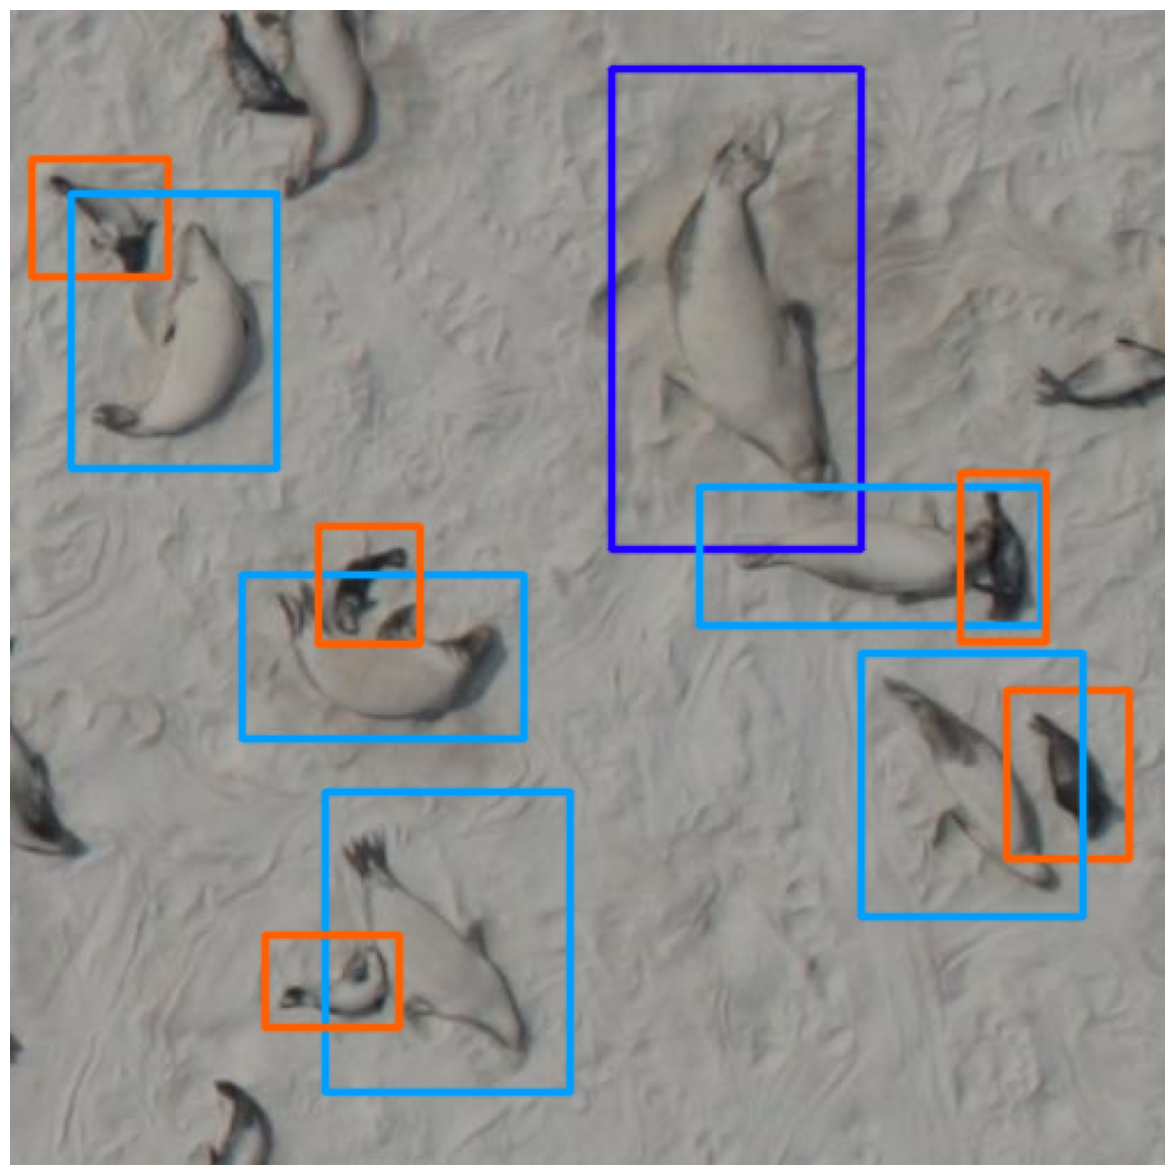

../../Data/elephant-seals/test/5MSL3436-6_png.rf.4ea434812bb5b4e80c37b85c5103168d.jpg


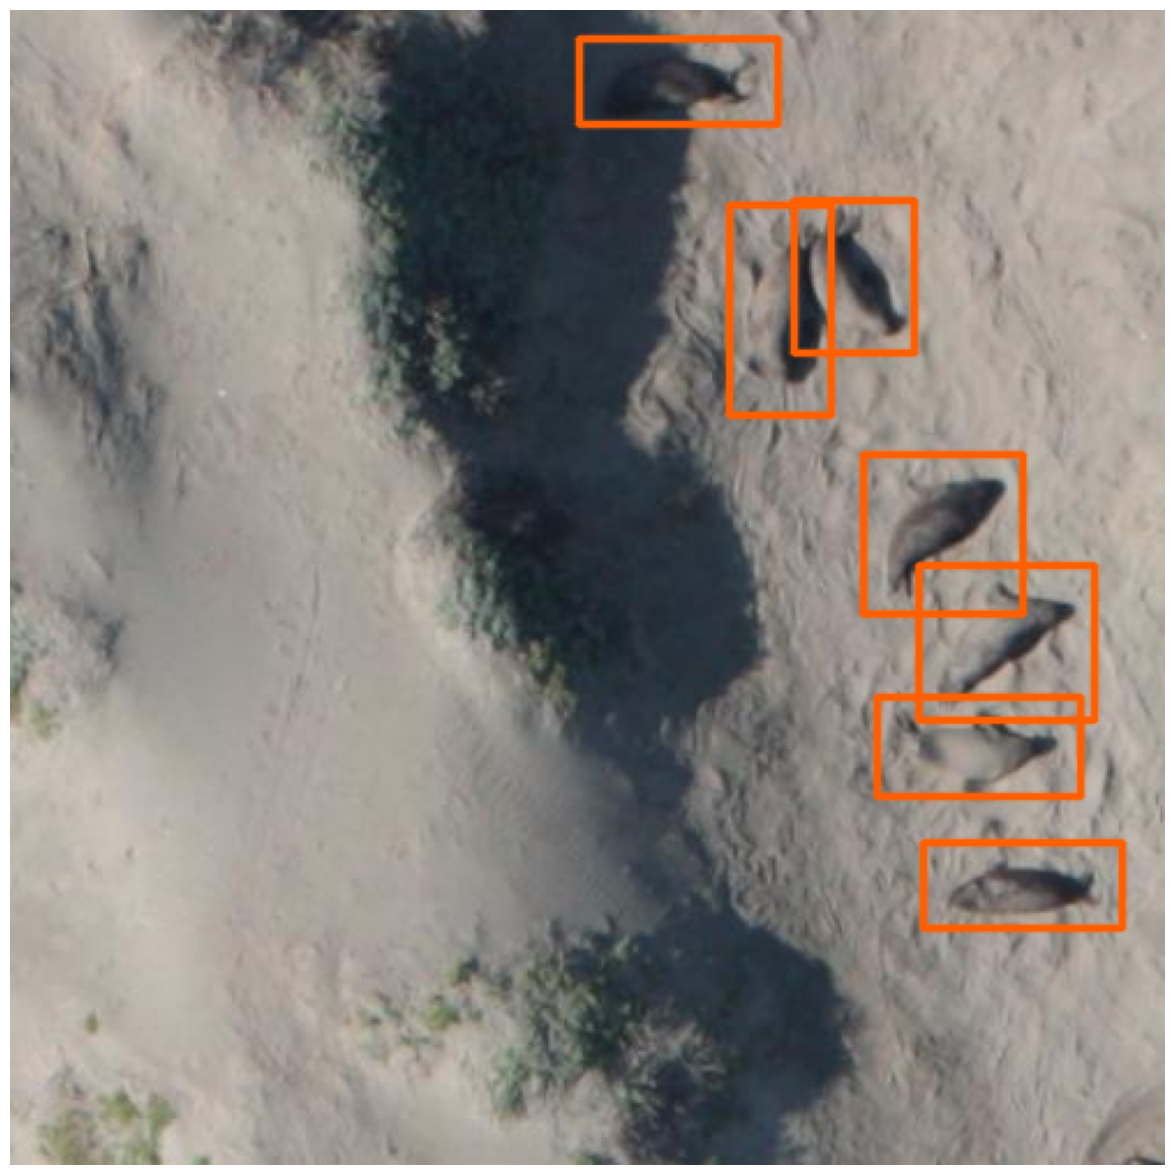

../../Data/elephant-seals/test/5MSL0109-95_png.rf.73ae554e192ba0a1cb271ec123f8330f.jpg


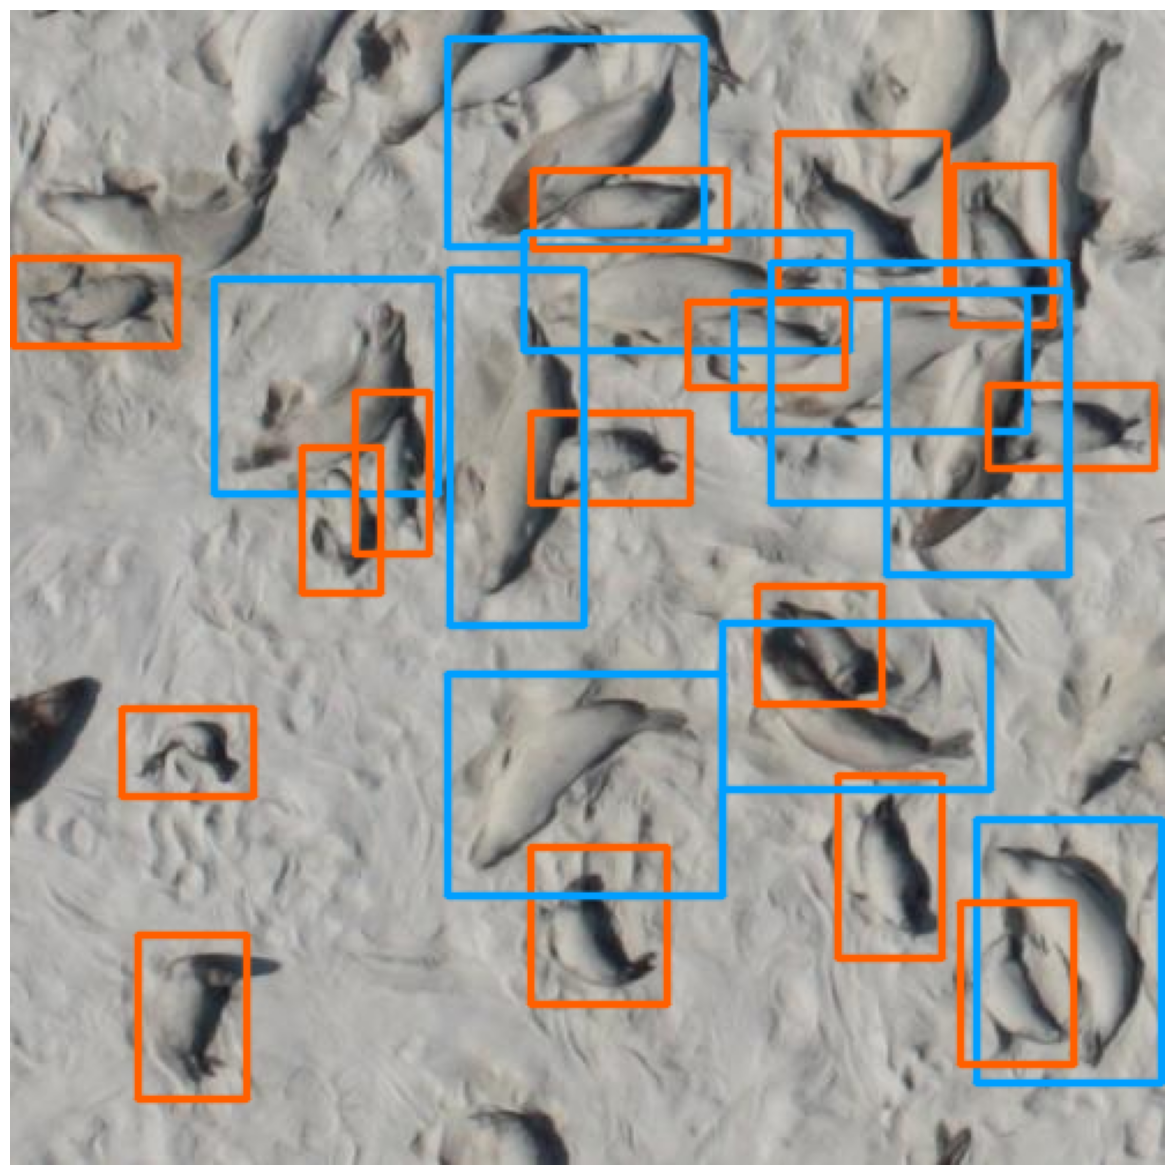

../../Data/elephant-seals/test/MA262988-171_png.rf.6d746f67067125adb31283c14052f12c.jpg


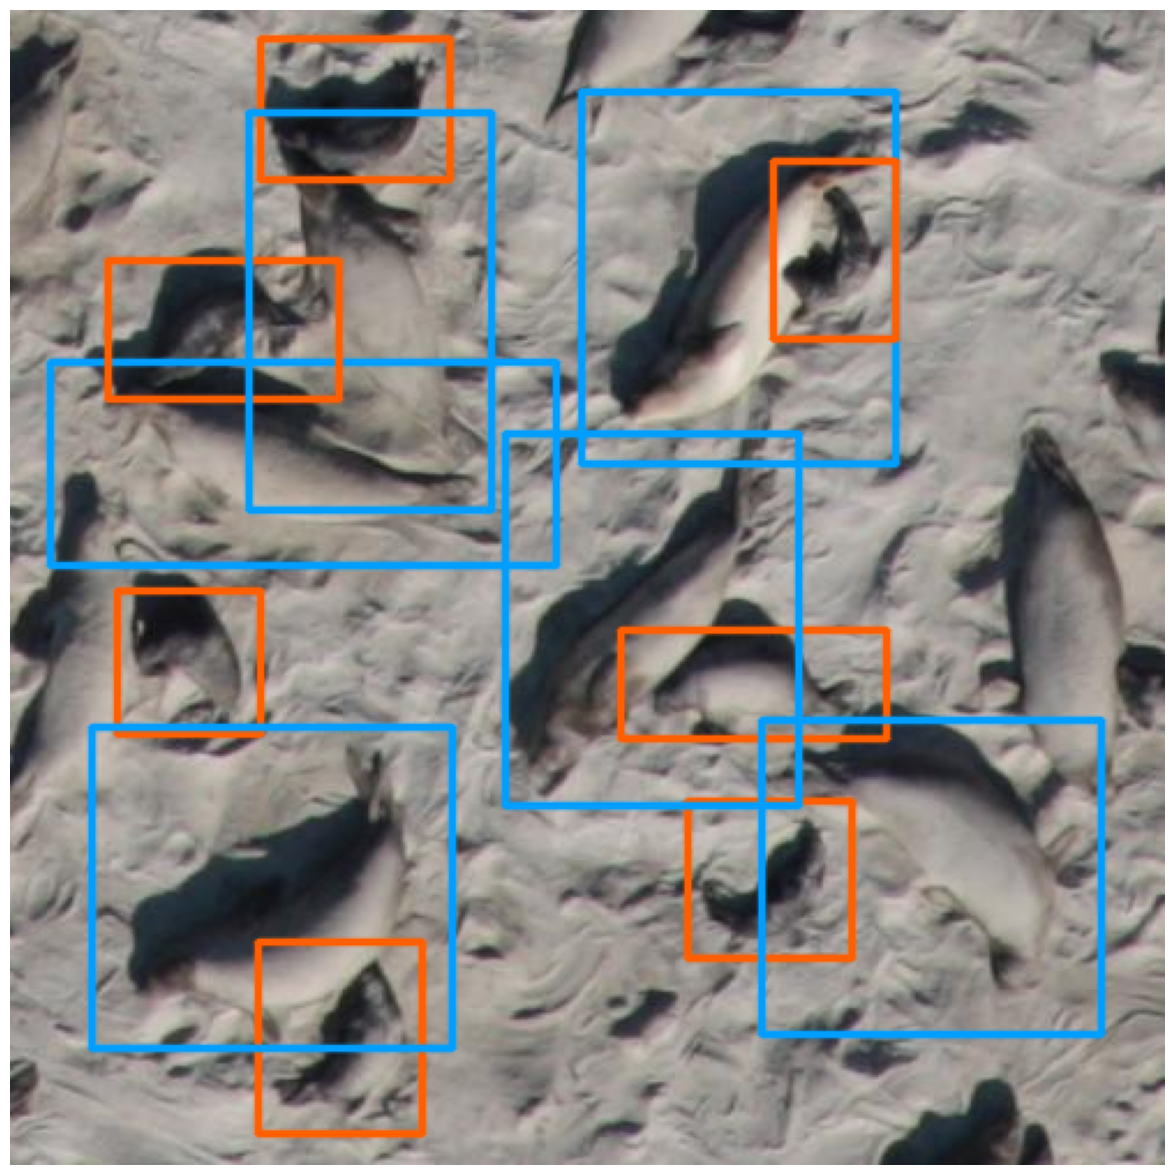

In [24]:
# visualize adjusted output
visualize = True
min_score = 0.5

for image_p in image_list: 
    image_path = image_prefix + image_p
    image = read_image_bgr(image_path)
    print(image_path)
    
    if visualize:
        draw = image.copy()
        draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
        
    image = preprocess_image(image)
    image, scale = resize_image(image)
    
    detections['../Data/image-level-split/test/' + image_p]
    boxes = [d['box'] for d in detections['../Data/image-level-split/test/' + image_p]]
    scores = [d['score'] for d in detections['../Data/image-level-split/test/' + image_p]]
    labels = [d['label'] for d in detections['../Data/image-level-split/test/' + image_p]]
    
    
    #boxes /= scale
    #if any(score >= min_score for score in scores[0]):
    #    detections[image_path] = []
    
    #for box, score, label in zip(boxes[0], scores[0], labels[0]):
    for i in range(len(boxes)):
        box = boxes[i]
        score = scores[i]
        label = labels[i]
        if score < min_score:
            break
        
        #b = box.astype(int)
        b = box
        #detections[image_path].append({"box" : b, "label" : label, "score" : score})
        
        # don't visualize the annotations along the edge of the tile
        if b[0] == 0 or b[1] == 0 or b[2] == 499 or b[3] == 499:
            continue
        
        if visualize: 
            # color = label_color(label)
            color = colors[label % 4]
            
            if label < 4:
                draw_box(draw, b, color=color, )
            else:
                draw_box_dashed(draw, b, color=color)
            
            # # uncomment the following to see labels and confidence scores
            # caption = "{} {:.3f}".format(labels_to_names[label], score)
            # draw_caption(draw, b, caption)
            
    if any(score >= min_score for score in scores):
        if visualize:
            plt.figure(figsize=(15, 15))
            plt.axis('off')
            plt.imshow(draw)
            plt.show()
